# Watson Assistant Workspace Analysis with User Logs


This guide demonstrates how to combine a Watson Data Notebook with Watson Assistant to analyze and improve a conversational application through establishing a baseline of performance and then creating, running and visualizing the results of experiments.  The pre-requisites for running this notebook are [IBM Cloudant](https://www.ibm.com/cloud/cloudant) and [Watson Assistant (formerly Watson Conversation).](http://www.ibm.com/watson/developercloud/conversation.html)  This notebook assumes familiarity with Watson Assistant and concepts such as workspaces, intents and training examples. For more information on getting started with the Watson Assistant, check out the [Watson Developer Cloud.](http://www.ibm.com/watson/developercloud/conversation.html)  Free plans for Watson Assistant and Cloudant are available and will work to get started with this notebook. 

During development of this notebook, the authors used the Car Dashboard sample workspace available to every Watson Assistant instance.  Other workspaces can be used instead.

### <span style="color:red">Key points about data usage: 
* This notebook will retrieve workspace data and log data from the Watson Assistant instance you configure in the notebook. 
* You will need to have two Assistant workspaces. One workspace should represent your production/baseline that you want to improve upon.  A second workspace should represent a test/experimental workspace that you will iteratively change and compare against your baseline. The first time you run the notebook, you may want your test/experimental workspace to be an exact clone of your production workspace. Then you can visualize subsequent changest to your test workspace as compared to that original baseline.
* The results of extracting logs from your baseline workspace, and results from calling your test/experiment workspace will be written to a Cloudant instance that you configure. If you prefer to store data elsewhere, you should modify the notebook steps that reference Cloudant.
* If you want to first try this notebook on sample data, you can use the Car Dashboard sample that is available with Watson Assistant. Simply use the Assistant User interface to create two copies of the Car Dashboard workspace, and generate user log data with the copy that you designate as your production/baseline workspace. To generate user log data, you can use a script like [generate_chat_logs](https://github.com/watson-developer-cloud/community/tree/master/watson-assistant#generate-chat-logs) and the sample [utterances-for-generate-chat-logs CSV file](https://github.com/watson-developer-cloud/community/blob/master/watson-assistant/utterances-for-generate-chat-logs.csv) available for download from the [Watson Community Github](https://github.com/watson-developer-cloud/community/tree/master/watson-assistant) repo. 

This notebook runs on Python.

## Table of Contents

This notebook is organized in four major sections. First, we setup the notebook with library imports and connections to Watson Assistant and Cloudant.  Then we'll define a set of supporting Python functions. Then we'll run the functions to gather data. Finally we'll graph the results for analysis and look for areas of improvement.   
________

1. [Install and import packages](#setup) 
2. [Prompt for Cloudant and Watson Assistant credentials](#credentials)
3. [Create the Cloudant database](#cloudant)
4. [Connect to Watson Assistant](#connect_assistant)<br>
Next, define a set of Python functions to interact with Cloudant and Watson Assistant.
5. [Get utterances from log data and store it in Cloudant for later use.](#get_logs)
6. [Send experiment questions to Test workspace](#send_questions)
7. [Create and Store Baseline ](#create_and_store_baseline)
8. [Get baselines from Cloudant ](#get_baselines)
9. [Define a function to run a specific experiment using baseline name](#run_experiment)
10. [Get previous experiments for a specific baseline](#get_experiments_for_baseline)
11. [Compute/Compile stats for a workspace ](#compile_workspace_stats)<br>
Function definitions end here. Now we'll run the functions to gather data. 
12. [Call the function to create and store the baseline ](#call_create_store_baseline)
13. [Call function to run experiment and store results ](#get_baseline_run_experiment)
14. [Compile workspace stats for baseline and experiment](#call_compile_workspace_stats)
15. [Prepare workspace analysis data and display the Intent distribution](#prepare_frames_display)<br>
Now we'll graph the results for analysis and look for areas of improvement.
16. [Compare the baseline vs. experiment workspaces](#display_ws_analysis)
17. [Display number of training examples in the workspace by intent.](#display_intent_analysis)
18. [Display the distribution of user utterances by intent using baseline vs. experiment workspaces](#display_intent_distribution_experiment)
19. [Display a log comparison of utterances sent to baseline vs. experiment workspaces](#display_experiment_run_dataframe)
20. [Summary and next steps](#summary)

________

## <a id="setup"></a> Step 1. Install and import packages

Install and import the necessary packages.

- <a href="https://github.com/watson-developer-cloud/python-sdk" target="_blank" rel="noopener no referrer">watson-developer-cloud</a> is the Python SDK for Watson Developer Cloud services
- <a href="https://docs.python.org/3/library/json.html" target="_blank" rel="noopener no referrer">json</a> is a Python module used here for manipulating the raw data for workspaces and logs. 
- <a href="https://pandas.pydata.org/" target="_blank" rel="noopener no referrer">pandas</a> is a Python library for processing and analyzing the baseline and experiment data.
- <a href="https://docs.python.org/3/library/datetime.html" target="_blank" rel="noopener no referrer">datetime</a> is a Python library used for naming the baseline and experiment files.
- <a href="https://docs.python.org/3/library/time.html" target="_blank" rel="noopener no referrer">time</a> is a Python library used for sleeping to limit rate limiting errors.
- <a href="https://docs.python.org/3/library/re.html" target="_blank" rel="noopener no referrer">re</a> is a Python library for regular expressions.

In [ ]:
#After running this cell once, comment out the following three lines of code. Packages only need to be installed once.
!pip install pixiedust
!pip install watson_developer_cloud
!pip install cloudant

#imports.... Run this each time after restarting the Kernel
import pixiedust #visualization

import json
import pandas
import datetime
from watson_developer_cloud import ConversationV1
import time
import re 

## <a id="credentials"></a> Step 2. Prompt for Cloudant and Watson Assistant credentials 
When you run this, you will be prompted to paste in a JSON string of the form shown in the code block below.
<br><i>Warning: Anyone with edit access to this Notebook will be able to read your credentials after you've run this cell.</i>

In [37]:
import getpass  
import pandas as pd

# Prompt the user for the JSON string of the form
#{
#  "assistant": {
#    "username": "XXXXXXXX",
#    "password": "XXXXXXXX",
#    "prod_workspace": "XXXXXXXX",
#    "test_workspace": "XXXXXXXX"
#  },
#  "cloudant": {
#    "username": "XXXXXXXX",
#    "password": "XXXXXXXX",
#    "url": "XXXXXXXX"
#  }
#}

credential_json = getpass.getpass('Please enter a JSON string with your Watson Assistant and Cloudant credentials of the form shown above.')
credentials = pd.read_json(credential_json, orient='values')

Please enter a JSON string with your Watson Assistant and Cloudant credentials of the form shown above.········


## <a id="cloudant"></a> Step 3.  Create the Cloudant database
Here we create the class that later functions will use.  
Be sure to update the name of the Cloudant database.

In [17]:
#Run this cell each time after restarting the Kernel
from cloudant.client import Cloudant

class cloudant_database(object):
    def __init__(self, db_name):
        self.db_name = db_name
        self.db = None
        self.client = None

    def login(self, username, password, url):
        self.client = Cloudant(username, password, url=url, connect=True)

    def create_database(self):
        self.db = self.client.create_database(self.db_name)

    def list_documents(self, pattern):
        docs = []
        for document in self.db:
            name = document["_id"]
            
            if name and re.match(pattern, name, re.I | re.M):
                docs.append(document)
        return docs

    def store_json_log(self, data, doc_id):
        try:
            self.db[doc_id]
        except:
            self.db.create_document({"_id":doc_id, "data": data})
            print('document added to Cloudant : {}'.format(doc_id))
        else:
            print('document exists')
                      
cdb = cloudant_database('conversation-analysis')

cdb.login(credentials.cloudant.username,
  credentials.cloudant.password,
  credentials.cloudant.url);

cdb.create_database()

## <a id="connect_assistant"></a> Step 4. Connect to Watson Assistant
Before you run this, be sure you have two workspaces in your Watson Assistant instance:
- One you want to treat as a baseline/production workspace, and 
- One you want to treat as your experiment workspace.

Update the two workspace references with your workspace IDs.

In [38]:

#create an SDK object for the baseline/production workspace (where to ask the questions to establish a true baseline)
conversation = ConversationV1( username=credentials.assistant.username, 
                                    password=credentials.assistant.password,
                                    version='2017-05-26')

# This is the baseline/production workspace
conversation_prod_ws = credentials.assistant.prod_workspace


#create an SDK object for the TEST workspace (where to ask the questions to establish true baseline)
conversation_test = ConversationV1( username=credentials.assistant.username, 
                                    password=credentials.assistant.password,
                                    version='2017-05-26')
#This is a experiment/test workspace
conversation_test_ws = credentials.assistant.test_workspace


## <a id="get_logs"></a> Step 5. Get utterances from log data and store it in Cloudant for later use
This function calls Watson Assistant API to retrieve logs, using pagination if necessary.
The goal is to retrieve utterances (user inputs) from the logs.

In [19]:
def get_logs(cursor, inputs, sdk_object, workspace_id, num_logs):
    
    page_limit = num_logs * 2 
        
    logs_response = sdk_object.list_logs(
             workspace_id = workspace_id,
             page_limit = num_logs,
             cursor = cursor
    )
    new_cursor = None

    if 'pagination' in logs_response:
        if 'next_url' in logs_response['pagination']:
            next_url = logs_response['pagination']['next_url']
            if next_url is not None:
                index = next_url.find('?cursor=')
                if index == -1:
                    index = next_url.find('&cursor=')
                if index != -1:
                    next_url = next_url[index + 8:]
                    index = next_url.find('&')
                    if index != -1:
                        next_url = next_url[:index]
                    new_cursor = next_url
    
    
    for log in logs_response["logs"]:
        try:
            input = log['request']['input']['text'].lower()
            if len(input) > 3: #we will (for now) ignore all utterances less than 3 chars long - need to revise
                inputs.append(input)
        except:
            pass
    inputs = list(set(inputs))
    if len(inputs) >= num_logs:
        inputs = inputs[:num_logs]
        print("got {} user utterances via logs API".format(len(inputs)) )
        return inputs
    
    if new_cursor is not None:
        time.sleep(0.05) #allow for a short break to try to limit rate limiting errors!
        cursor, inputs, sdk_object, workspace_id, num_logs
        inputs = get_logs(cursor=new_cursor, inputs = inputs, 
                          sdk_object = sdk_object, workspace_id = workspace_id, 
                          num_logs = num_logs)
              
    return inputs


## <a id="send_questions"></a> Step 6. Send experiment questions to test workspace 
This function sends a set of questions captured previously from logs, extracts utterances and sends to Watson Assistant.

Capture the responses and return that to the caller of this function. 

In [39]:
def send_questions_and_get_workspace(conversation, workspace_id, logs, store_logs):
    #for each utterance returned re-ask it against the 'test' workspace (the workspace against which you will be running the experiment)
    responses = []
    data = {}
    i = 0
    progress = 10;
    if len(logs) > 50: 
        progress = 20
    if len(logs) > 100:
        progress = 25
    if len(logs) > 500:
        progress = 50
        
    for question in logs:
    
        i += 1
        conversation_response = conversation.message(
          workspace_id = workspace_id, 
            input = {'text': question}
        )
        #Save the result in the form:
        #{'text' : 'original question asked by user, retrieved from logs', 
        # 'intents':'the intents payload returned by the Watson Assistant API call',
        # 'entities' : 'the entities payload returned by the conversation API call'}
        intents = conversation_response['intents']
        if len(intents) == 0:
            intents = []
            intents.append({"intent" : "irrelevant", "confidence" : 1.0})
        result = {'text' : conversation_response['input']['text'], 'intents' : intents, 'entities' : conversation_response['entities']}
        responses.append(result);
        if i%progress == 0:
            print("{} of {} questions processed..".format(i, len(logs)))

    #We have sent all the questions through the latest workspace - store the workspace also
    print("All {} questions processed..".format(i))
    workspace_json = conversation.get_workspace(workspace_id=workspace_id, export=True)
    data['results'] = responses
    data['workspace'] = workspace_json
    if store_logs == True:
        data['logs'] = logs
    return data

## <a id="create_and_store_baseline"></a> Step 7. Create and store baseline 
This function retrieves logs and sends to another function to capture responses with a test workspace.

Store the results in Cloudant in a new table prefixed with BL_ and including the current date and time for later analysis.


In [40]:
def create_and_store_baseline(size):
    logs = get_logs(cursor = None, inputs=[], 
            sdk_object = conversation, 
             workspace_id = conversation_prod_ws, 
             num_logs = size)

    #send_questions_and_get_workspace(conversation, workspace_id, logs):
    print("Sending questions to Watson Assistant....")
 
    document_to_store = send_questions_and_get_workspace(conversation = conversation_test, 
                                                         workspace_id = conversation_test_ws, 
                                                         logs = logs, store_logs = True)
    #Once all questions have been re-asked against the latest workspace store the results in Cloudant
    timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H%M%S")
    name = "BL_" + timestamp
    document_to_store["name"] = name
    
    cdb.store_json_log(document_to_store, name) # store responses

## <a id="get_baselines"></a> Step 8. Get baselines from Cloudant 
This function calls our Cloudant function to get documents that adhere to our naming convention for baseline documents.
 

In [41]:
def get_all_baselines () :
    return cdb.list_documents("^BL_\d{4}_\d{2}_\d{2}_\d{6}$")

## <a id="run_experiment"></a> Step 9. Define a function to run a specific experiment using baseline name
This function gets a baseline by name and runs the questions against a test workspace. 

In [42]:
def run_experiment (baseline_name) :
    baselines = get_all_baselines()
    stored_baseline = None
    document_to_store = None
    for baseline in baselines:
        if (baseline["_id"] == baseline_name):
            stored_baseline = baseline["data"]
            print ("Found baseline: {}".format(baseline_name))
            if "logs" in stored_baseline:
                print ("Sending experiment questions to Watson Assistant...")
                logs = stored_baseline["logs"]
                document_to_store = send_questions_and_get_workspace(conversation = conversation_test, 
                                                                     workspace_id = conversation_test_ws, 
                                                                     logs = logs, store_logs = False)
                return document_to_store
            else:
                print("LOGS WERE NOT STORED IN BASELINE.... EXITING!!!!")
            
    return None       

## <a id="get_experiments_for_baseline"></a> Step 10. Get previous experiments for a specific baseline 
This function gets Cloudant experiment documents associated with a specific baseline.  

In [43]:
def get_experiments_for_baseline(baseline):
    return cdb.list_documents("^" + baseline + "__EX__\d{4}_\d{2}_\d{2}_\d{6}$")

## <a id="compile_workspace_stats"></a> Step 11. Compute and compile stats for a workspace 
This function calculates stats about intents, entities (including values and synonyms) and dialog notes.


In [44]:
def compile_workspace_stats(workspace_json):
    intents = workspace_json['intents']
    entities = workspace_json['entities']
    #print(json.dumps(intents, indent=4, sort_keys=True))

    intents_len =  len(intents)
    dialog_nodes_len = len(workspace_json['dialog_nodes'])
    entities_len = len(entities)

    # print(intents_len, entities_len)
    examples_len = 0
    intent_info = [];

    for intent in intents:
        intent_info.append({'intent' : intent['intent'], 'len' : len(intent['examples'])})
        examples_len += len(intent['examples'])

    values_len = 0
    synonyms_len = 0
    values_len = 0

    for entity in entities:
      values_len += len(entity['values'])
      for value in entity['values']:
        synonyms_len += (len(value['synonyms']))

    stats = {}
    stats['ws_stats'] = [{'name' : 'entities', 'len' : entities_len},
    {'name' : 'values', 'len' : values_len},
    {'name' : 'synonyms', "len" : synonyms_len},
    {'name' : 'intents', 'len' : intents_len},
    {'name' : 'examples', 'len' : examples_len},
    {'name' : 'dialog_nodes', 'len' : dialog_nodes_len}]


    return stats, intent_info

## <a id="call_create_store_baseline"></a> Step 12. Call the function to create and store a new baseline
Calls function, passing in max number of utterances.

**Note:** This assumes that you have log data available for the workspace you've set as `conversation_prod_ws`, as shown in Step 7. 
This step will run the those logs as utterances against the workspace you've set as `conversation_test_ws.` 

**Exercise caution: If you have already run this function, running it again will overwrite your baseline used for comparison.** You may want to comment out the following row if you are iterating on changes to your experiments and wish to retain your original baseline.

In [26]:
create_and_store_baseline(size = 700)

got 700 user utterances via logs API
Sending questions to Watson Assistant....
50 of 700 questions processed..
100 of 700 questions processed..
150 of 700 questions processed..
200 of 700 questions processed..
250 of 700 questions processed..
300 of 700 questions processed..
350 of 700 questions processed..
400 of 700 questions processed..
450 of 700 questions processed..
500 of 700 questions processed..
550 of 700 questions processed..
600 of 700 questions processed..
650 of 700 questions processed..
700 of 700 questions processed..
All 700 questions processed..
document added to Cloudant : BL_2018_04_16_154554


## <a id="get_baseline_run_experiment"></a> Step 13. Call function to run experiment and store results 
Pick one baseline and run experiment with that.
 

In [45]:
baselines = get_all_baselines()
baseline_name = baselines[len(baselines) - 1]["_id"]
experiment = run_experiment(baseline_name = baseline_name)

# store experiment result with convention of using the baseline name and the experiment date time
name = baseline_name + "__EX__" + datetime.datetime.now().strftime("%Y_%m_%d_%H%M%S")
experiment["name"] = name
cdb.store_json_log(experiment, name) # store experiment

Found baseline: BL_2018_04_16_154554
Sending experiment questions to Watson Assistant...
50 of 700 questions processed..
100 of 700 questions processed..
150 of 700 questions processed..
200 of 700 questions processed..
250 of 700 questions processed..
300 of 700 questions processed..
350 of 700 questions processed..
400 of 700 questions processed..
450 of 700 questions processed..
500 of 700 questions processed..
550 of 700 questions processed..
600 of 700 questions processed..
650 of 700 questions processed..
700 of 700 questions processed..
All 700 questions processed..
document added to Cloudant : BL_2018_04_16_154554__EX__2018_04_16_155421


## <a id="call_compile_workspace_stats"></a> Step 14. Compile workspace stats for baseline and experiment
Gets stats for the workspace associated with last baseline and last experiment.
 

In [46]:
baselines = get_all_baselines()
baseline_name = baselines[len(baselines) - 1]["_id"]
workspace = baselines[len(baselines) - 1]["data"]["workspace"]
base_ws_stats = compile_workspace_stats(workspace_json=workspace)

experiments = get_experiments_for_baseline(baseline=baseline_name)
workspace = experiments[len(experiments) - 1]["data"]["workspace"]
exp_ws_stats = compile_workspace_stats(workspace_json=workspace)

## <a id="prepare_frames_display"></a> Step 15. Prepare workspace analysis data and display the intent distribution
- Create an intent distribution of the results from the baseline and the experiment (and display the comparison).
- Create another data frame for analysis of intents in each workspace, counting the number of examples for each intent.
- Create another data frame for more complete analysis of each workspace including entities.


In [47]:
import pandas

#count how many times each intent was used per experiment run
count = {}

baselines = get_all_baselines()
baseline_name = baselines[len(baselines) - 1]["_id"]
prod_ws = baselines[len(baselines) - 1]["data"]["workspace"]
baseline = baselines[len(baselines) - 1]["data"]["results"]

experiments = get_experiments_for_baseline(baseline=baseline_name)
experiment_name = experiments[len(experiments) - 1]["_id"]
test_ws = experiments[len(experiments) - 1]["data"]["workspace"]
experiment_results = experiments[len(experiments) - 1]["data"]["results"]

for row in baseline:
    name = row['intents'][0]['intent']
    if name not in count:
        count[name] = {'ex1' : 0, 'ex2' : 0}
    count[name]['ex1'] = count[name]['ex1'] + 1

for row in experiment_results:
    name = row['intents'][0]['intent']
    
    if name not in count:
        count[name] = {'ex1' : 0, 'ex2' : 0}
        
    count[name]['ex2'] = count[name]['ex2'] + 1   
    
arr = []    
for key in count:
    arr.append({'intent name' : key, 'baseline' : count[key]['ex1'], 'experiment' : count[key]['ex2']})
    
intent_distribution_df = pandas.DataFrame(arr)

ws_analysis = [] 
ws_analysis.append({'workspace component' : 'intents', 'baseline' : len(prod_ws['intents']), 'experiment' : len(test_ws['intents'])})
ws_analysis.append({'workspace component' : 'entities', 'baseline' : len(prod_ws['entities']), 'experiment' : len(test_ws['entities'])})
ws_analysis.append({'workspace component' : 'dialog_nodes', 'baseline' : len(prod_ws['dialog_nodes']), 'experiment' : len(test_ws['dialog_nodes'])})
ws_analysis.append({'workspace component' : 'counterexamples', 'baseline' : len(prod_ws['counterexamples']), 'experiment' : len(test_ws['counterexamples'])})
prod_examples = 0

intent_analysis = []
intent_analysis.append({'intent' : 'irrelevant', 'baseline': len(prod_ws['counterexamples']), 'experiment' : len(test_ws['counterexamples'])})

for intent in prod_ws['intents']:
    prod_examples = prod_examples + len(intent['examples'])
    intent_analysis.append({'intent' : intent['intent'], 'baseline' : len(intent['examples']), 'experiment' : 0})
    
test_examples = 0
for intent in test_ws['intents']:
    test_examples = test_examples + len(intent['examples'])
    found = False
    for intnt in intent_analysis:
        if intnt['intent'] == intent['intent']:
            found = True
            intnt['experiment'] = len(intent['examples'])
            break
                                      
    if not found: 
        intent_analysis.append({'intent' : intent['intent'], 'baseline' : 0, 'experiment' : len(intent['examples'])})
 
ws_analysis.append({'workspace component' : 'examples', 'baseline' : prod_examples, 'experiment' : test_examples})

prod_values = 0
prod_synonyms = 0
for entity in prod_ws['entities']:
    prod_values = prod_values + len(entity['values'])
    for value in entity['values']:
        prod_synonyms = prod_synonyms + len(value['synonyms'])
        
test_values = 0
test_synonyms = 0
for entity in test_ws['entities']:
    test_values = test_values + len(entity['values'])
    for value in entity['values']:
        test_synonyms = test_synonyms + len(value['synonyms'])
    

ws_analysis.append({'workspace component' : 'values', 'baseline' : prod_values, 'experiment' : test_values})
ws_analysis.append({'workspace component' : 'synonyms', 'baseline' : prod_synonyms, 'experiment' : test_synonyms})

ws_analysis_df = pandas.DataFrame(ws_analysis)
intent_analysis_df = pandas.DataFrame(intent_analysis)

# make a data frame with the original utterance, the intent from each run, 
# the confidence, whether or not the intent changed, and the confidence delta
merged1 = [{"text": b["text"], "intent_1" : b['intents'][0]['intent'], 
           "conf_1" : b['intents'][0]['confidence']} for b in baseline]
merged2 =[{"text": b["text"], "intent_2" : b['intents'][0]['intent'], 
           "conf_2" : b['intents'][0]['confidence']} for b in experiment_results]
merged = list(zip(merged1, merged2))

merged = [{'intent_1': b[0]['intent_1'], 'conf_1': b[0]['conf_1'],
          'intent_2': b[1]['intent_2'], 'conf_2': b[1]['conf_2'], 
          'intent_changed' : b[0]['intent_1'] != b[1]['intent_2'],
          'conf_delta' : b[1]['conf_2'] - b[0]['conf_1'], 'text' : b[0]['text']} for b in merged]

experiment_run_dataframe = pandas.DataFrame(merged)

# Code below filters out all information except for cases where the intent had been changed between baseline and experiment.
# comment out the following to see all questions in the experiment/baseline
experiment_run_dataframe = experiment_run_dataframe.loc[experiment_run_dataframe['intent_changed']==True]

#pdf = pdf.loc[pdf['conf_delta']>0.1]
#display(pdf)

## <a id="display_ws_analysis"></a> Step 16. Compare the baseline vs. experiment workspaces 
Compare aspects of baseline vs. experiment workspace. 

In [48]:
ws_analysis_df

,baseline,experiment,workspace component
0,25,27,intents
1,13,13,entities
2,142,142,dialog_nodes
3,6,6,counterexamples
4,2520,2650,examples
5,115,116,values
6,329,393,synonyms



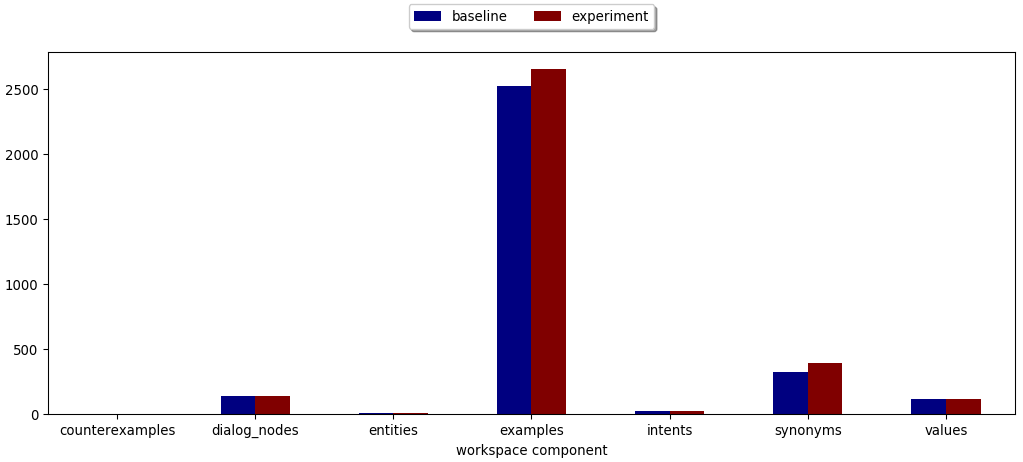

In [54]:
display(ws_analysis_df)

## <a id="display_intent_analysis"></a> Step 17. Display number of training examples in the workspace by intent
 Intent analysis


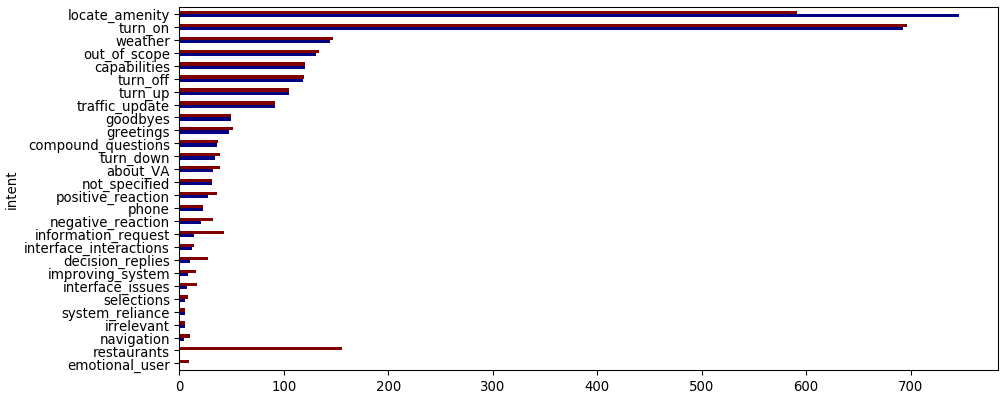

In [50]:
display(intent_analysis_df)

## <a id="display_intent_distribution_experiment"></a> Step 18.  Display the distribution of user utterances by intent using baseline vs. experiment workspaces


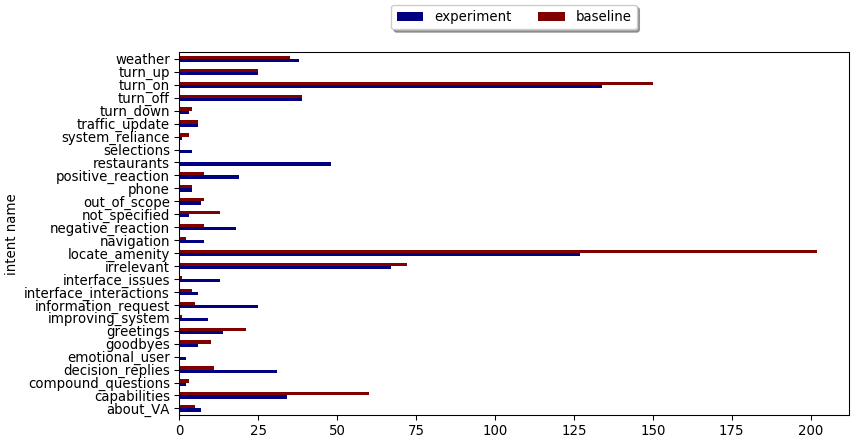

In [51]:
# Display the distribution of user utterances by intent using baseline vs. experiment workspaces
display(intent_distribution_df)

## <a id="display_experiment_run_dataframe"></a> Step 19.  Display a log comparison of utterances sent to baseline vs. experiment workspaces

In [52]:
# This will show only utterances where the intent changed between the baseline and the experiment 
display(experiment_run_dataframe)

conf_1,conf_2,conf_delta,intent_1,intent_2,intent_changed,text
0.34756040573120117,0.9205888271331788,0.5730284214019776,locate_amenity,navigation,True,can you go faster?
0.27617664800476405,1.0,0.723823351995236,capabilities,irrelevant,True,i have some issues with the training that i did yesterday
1.0,1.0,0.0,irrelevant,information_request,True,discover who framed roger rabbit
0.4576628923416138,0.465980339050293,0.008317446708679233,turn_up,locate_amenity,True,ac at 65
0.8080081939697266,1.0,0.19199180603027344,locate_amenity,information_request,True,tell me about kiit
1.0,1.0,0.0,irrelevant,positive_reaction,True,okey
0.3003031492233277,0.8087086200714111,0.5084054708480834,goodbyes,locate_amenity,True,rest
0.38299791812896733,1.0,0.6170020818710327,locate_amenity,interface_issues,True,which one
1.0,1.0,0.0,irrelevant,information_request,True,what is the capital of the united states?
0.49260892868041994,1.0,0.5073910713195801,negative_reaction,irrelevant,True,im dat


## <a id="summary"></a> Summary and next steps
You've learned how to use the Watson Assistant API to perform workspace analysis and track experiments against a baseline.
Try using your own workspace and log data to make improvements for your Watson Assistant application!


Learn more:
- <a href="https://www.ibm.com/watson/developercloud/conversation/api/v1/" target="_blank" rel="noopener noreferrer">Watson Assistant API reference</a>
- <a href="https://github.com/watson-developer-cloud/python-sdk" target="_blank" rel="noopener noreferrer">Watson Assistant Python SDK</a>

### <a id="authors"></a>Authors


**Dan O'Connor** is a Senior Software Engineer with the Watson Assistant (formerly Conversation Service) in IBM. Dan has a background in writing End User tools for various platforms ranging from WebSphere to Watson. Dan has been a member of the Watson team since 2013 where he has focused on building web applications which allow users of the Watson products/services to more easily configure and train the various the machine learning algorithms in use by those services.

**Eric Wayne** is Senior Technical Staff Member and Development Manager for IBM Watson AI. Eric joined Watson in 2014 and has led development of Watson solutions for discovery and conversational assistants for multiple industry domains.

Copyright © 2018 IBM. This notebook and its source code are released under the terms of the MIT License.

<div style="background:#F5F7FA; height:110px; padding: 2em; font-size:14px;">
<span style="font-size:18px;color:#152935;">Love this notebook? </span>
<span style="font-size:15px;color:#152935;float:right;margin-right:40px;">Don't have an account yet?</span><br>
<span style="color:#5A6872;">Share it with your colleagues and help them discover the power of Watson Studio!</span>
<span style="border: 1px solid #3d70b2;padding:8px;float:right;margin-right:40px; color:#3d70b2;"><a href="https://ibm.co/wsnotebooks" target="_blank" style="color: #3d70b2;text-decoration: none;">Sign Up</a></span><br>
</div>